# WIPRO TIME SERIERS - ANOMALY DETECTION AND SEQUENCE PREDICTION

**Requirements**

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch import optim
import torch.nn.functional as F

%matplotlib inline
%env CUDA_VISIBLE_DEVICES=0

USE_CUDA = torch.cuda.is_available()

env: CUDA_VISIBLE_DEVICES=0


**Build recurrent anttention based model**

The idea being learn the sequential dependencys and structure via gated rnn,
and to learn spatial structure and similarity via attention mechanism. 

The Attention used in this case is inspired by https://arxiv.org/pdf/1508.04025.pdf
Where the context vector is appended to final hiddent state and are passed to output layer.
This differs to the standerd case where context is appended to input of the reccurent cell.

The RNN sequence is inspired by https://arxiv.org/pdf/1308.0850.pdf
Where LSTM based models are used for pedicting next time step.

The code is mostly based on code found here:
http://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

** Recurrent model for capturing sequential information**

In [2]:
class SequencePredRNN(nn.Module):
    def __init__(self, input_size, hidden_size, n_layers=1):
        super(SequencePredRNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

    def forward(self, inputs, hidden):
        output = inputs
        for i in range(self.n_layers):
            output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        result = Variable(torch.zeros(1, 1, self.hidden_size))
        if USE_CUDA:
            return result.cuda()
        else:
            return result

** Attention model utilize reccurnt ouputs and their spatial similarity for predicting next time step**

In [3]:
class AttendAndPredict(nn.Module):
    """Attention nn module that is responsible for computing the alignment scores."""

    def __init__(self, method, hidden_size, output_size):
        super(AttendAndPredict, self).__init__()
        self.method = method
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Define layers
        if self.method == 'general':
            self.attention = nn.Linear(self.hidden_size, self.hidden_size)
        elif self.method == 'concat':
            self.attention = nn.Linear(self.hidden_size * 2, self.hidden_size)
            self.other = nn.Parameter(torch.FloatTensor(1, self.hidden_size))
            
        self.fc_out = nn.Linear(self.hidden_size * 2, self.output_size)
        
        

    def forward(self, hidden, M):
        """Attend over N rnn sequence prediction outputs till time t-1 (t-2-N...t-1).
        
        After creating variables to store the attention energies, calculate their 
        values for each encoder output and return the normalized values.
        
        Args:
            hidden: decoder hidden output used for condition.
            M: memory of which to attend overe.
            
        Returns:
             Normalized (0..1) energy values, re-sized to 1 x 1 x seq_len
        """
        
        seq_len = len(M)
        if USE_CUDA:
            energies = Variable(torch.zeros(seq_len)).cuda()
        else:
            energies = Variable(torch.zeros(seq_len))
            
        for i in range(seq_len):
            energies[i] = self._score(hidden, M[i])
        a = F.softmax(energies).unsqueeze(0).unsqueeze(0)
        c = torch.mm(M,a)
        next_timestep_prediction = self.fc_out(torch.cat((c, hidden), 1))
        
        return next_timestep_prediction
        
    def _score(self, hidden, M):
        """Calculate the relevance of a particular encoder output in respect to the decoder hidden."""

        if self.method == 'dot':
            energy = hidden.dot(M)
        elif self.method == 'general':
            energy = self.attention(M)
            energy = hidden.dot(energy)
        elif self.method == 'concat':
            energy = self.attention(torch.cat((hidden, M), 1))
            energy = self.other.dor(energy)
        return energy


** Training procedure**

Train per time window

In [4]:
def train(input_seq, seqrnn_model, atten_model, memory_size, criterion, optimizer):
    """
    Train for a given sequence batch size.
    Args:
    input_seq(batch_size,seq_len,input_size): tensor containin sequences.
    seqrnn_model: input model - batch is first dim.
    memory_size: size of matrix to attend over.
    criterion: distance measure i.e. l1, l2 etc.
    optimizer: GD, ADAM etc.
    """
    
    seq_rnn_hidden = seqrnn_model.initHidden()
    seqrnn_model.zero_grad()
    atten_model.zero_grad()
    
    batch_size = input_seq.size()[0]
    seq_len = input_seq.size()[1]
    
    print(batch_size)
    print(seq_len)
    
    assert memory_size < seq_len, 'memory should be smaller than total seq'
    
    seqrnn_output = Variable(torch.zeros(seq_len, batch_size, seqrnn_model.hidden_size))
    seqrnn_output[:] = seqrnn_model.cuda() if USE_CUDA else seqrnn_model
    
    loss = 0
    
    seqrnn_output, hidden = seqrnn_model(seqrnn_model, seq_rnn_hidden) # in case of 1 rnn layer output == hidden.
    #
    # Start prediction from time t + memory_size till time T - memory_size
    for t in range(seq_len - memory_size):
        M = seqrnn_output[:,i:memory_size+i-1] # memory matrix i.e. attend over
        h = seqrnn_output[:,memory_size+t] # current rnn pred
        preds = atten_model(h, M)
        loss += criterion(preds, input_seq[:,memory_size+t])
        
    loss.backward()
    seqrnn_model.step()
    atten_model.step()
    
    return loss.data[0] / target_length
        

This is a helper function to print time elapsed and estimated time remaining given the current time and progress %.

In [5]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

Full train procedure

In [6]:
def trainIters(train_data, recurrent_model, attention_model, n_iters,
               print_every=1000, plot_every=100, learning_rate=0.01):
    
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    optimizer = optim.SGD(nn.ModuleList([recurrent_model, attention_model]).parameters(), lr=learning_rate)
    training_pairs = [] # TODO: Need to add functionatly here
    criterion = nn.L1Loss()

    for iter in range(1, n_iters + 1):
        
        input_variable = train_data[iter,:].unsqueeze(0)

        loss = train(input_variable, recurrent_model,
                     attention_model, 10, optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [7]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np


def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

Temprorery gen syntetic data for debugging model

In [8]:
import numpy as np

T = 20
L = 1000
N = 100

x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4 * T, 4 * T, N).reshape(N, 1)
data = Variable(torch.from_numpy(np.sin(x / 1.0 / T).astype('float64')), requires_grad=False)

example data


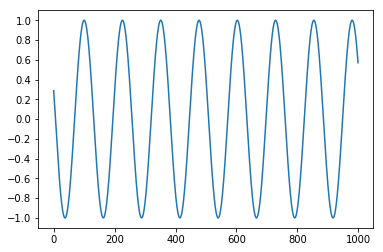

In [9]:
print('example data')
show_plot(data[1,:].data.numpy())

** Main Entry Point **

In [10]:
hidden_size = 1
seqrnn = SequencePredRNN(1, 1)
attn = AttendAndPredict('general', 1, 1)

if USE_CUDA:
    seqrnn = seqrnn.cuda()
    seqrnn = seqrnn.cuda()

trainIters(data, seqrnn, attn, 75000, print_every=5000)

1
1000


RuntimeError: copy from SequencePredRNN to torch.FloatTensor isn't implemented